#### Python Spark ML model tuning
#### https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml
#### https://www.kaggle.com/harlfoxem/housesalesprediction#kc_house_data.csv

In [1]:
#https://www.nodalpoint.com/spark-data-frames-from-csv-files-handling-headers-column-types/
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import udf,col,dayofmonth,dayofyear,dayofweek,year,weekofyear,to_timestamp,to_date,unix_timestamp
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import numpy as np
from datetime import *
from dateutil.parser import parse
parse("2013-02-09 18:16:10")

datetime.datetime(2013, 2, 9, 18, 16, 10)

In [2]:
sc = SparkContext(appName="CSV2Parquet")
sqlContext = SQLContext(sc)

In [3]:
#smarter load of the csv file with a header 
houseFile = sqlContext.read.load("./work/kc_house_data.csv", format='com.databricks.spark.csv', header='true', inferSchema='true')
print(houseFile)

DataFrame[id: bigint, date: string, price: decimal(7,0), bedrooms: int, bathrooms: double, sqft_living: int, sqft_lot: int, floors: double, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int]


In [4]:
parseString =  udf(lambda x: datetime.strptime(x, '%Y%m%d'), TimestampType())
houseFile = houseFile
houseFile=(
    houseFile.withColumn('datetime', houseFile.date.substr(1, 8))
    .withColumn('date_parsed', parseString(col('datetime'))))
houseFile.head(1)

[Row(id=7129300520, date='20141013T000000', price=Decimal('221900'), bedrooms=3, bathrooms=1.0, sqft_living=1180, sqft_lot=5650, floors=1.0, waterfront=0, view=0, condition=3, grade=7, sqft_above=1180, sqft_basement=0, yr_built=1955, yr_renovated=0, zipcode=98178, lat=47.5112, long=-122.257, sqft_living15=1340, sqft_lot15=5650, datetime='20141013', date_parsed=datetime.datetime(2014, 10, 13, 0, 0))]

In [5]:
houseFile=(
    houseFile.withColumn('wd',dayofweek(houseFile.date_parsed))
    .withColumn('dd',dayofmonth(houseFile.date_parsed))
    .withColumn('yyyy',year(houseFile.date_parsed))
    .withColumn('woy',weekofyear(houseFile.date_parsed))
    .withColumnRenamed("price","label")
         )
houseFile.head(1)

[Row(id=7129300520, date='20141013T000000', label=Decimal('221900'), bedrooms=3, bathrooms=1.0, sqft_living=1180, sqft_lot=5650, floors=1.0, waterfront=0, view=0, condition=3, grade=7, sqft_above=1180, sqft_basement=0, yr_built=1955, yr_renovated=0, zipcode=98178, lat=47.5112, long=-122.257, sqft_living15=1340, sqft_lot15=5650, datetime='20141013', date_parsed=datetime.datetime(2014, 10, 13, 0, 0), wd=2, dd=13, yyyy=2014, woy=42)]

In [6]:
columns_to_drop = ['id','date','datetime','date_parsed','sqft_living15','sqft_lot15']
houseFile = houseFile.drop(*columns_to_drop)

In [7]:
houseFile.head(1)

[Row(label=Decimal('221900'), bedrooms=3, bathrooms=1.0, sqft_living=1180, sqft_lot=5650, floors=1.0, waterfront=0, view=0, condition=3, grade=7, sqft_above=1180, sqft_basement=0, yr_built=1955, yr_renovated=0, zipcode=98178, lat=47.5112, long=-122.257, wd=2, dd=13, yyyy=2014, woy=42)]

In [8]:
def prettySummary(df):
    """ Neat summary statistics of a Spark dataframe
    Args:
        pyspark.sql.dataframe.DataFrame (df): input dataframe
    Returns:
        pandas.core.frame.DataFrame: a pandas dataframe with the summary statistics of df
    """
    import pandas as pd
    temp = df.describe().toPandas()
    temp.iloc[1:3,1:] = temp.iloc[1:3,1:].apply(pd.to_numeric, errors='coerce')
    pd.options.display.float_format = '{:,.2f}'.format
    return temp
prettySummary(houseFile)

,summary,label,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,wd,dd,yyyy,woy
0,count,21613,21613,21613,21613,21613,21613,21613,21613,21613,...,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613
1,mean,"540,088.14",3.37,2.11,"2,079.90","15,106.97",1.49,0.01,0.23,3.41,...,291.51,"1,971.01",84.40,"98,077.94",47.56,-122.21,3.94,15.69,"2,014.32",26.87
2,stddev,"367,127.20",0.93,0.77,918.44,"41,420.51",0.54,0.09,0.77,0.65,...,442.58,29.37,401.68,53.51,0.14,0.14,1.43,8.64,0.47,13.50
3,min,75000,0,0.0,290,520,1.0,0,0,1,...,0,1900,0,98001,47.1559,-122.519,1,1,2014,1
4,max,7700000,33,8.0,13540,1651359,3.5,1,4,5,...,4820,2015,2015,98199,47.7776,-121.315,7,31,2015,52


In [9]:
houseFile.write.mode('overwrite').parquet('./work/house-parquet')

In [10]:
df = sqlContext.read.parquet('./work/house-parquet')

In [11]:
# Define the workflow
feature_list = []
for col in df.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

rf = RandomForestRegressor(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf])


In [12]:
# Hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

(trainingData, testData) = df.randomSplit([0.8, 0.2])

cvModel = crossval.fit(trainingData)

predictions = cvModel.transform(testData)

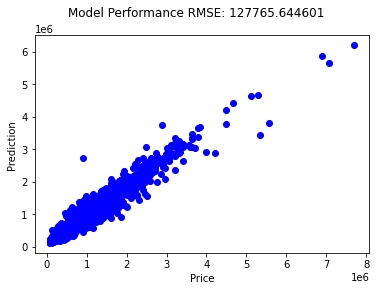

1.8

In [13]:
# Evaluate
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(df)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

round(233941.72 / rmse, 1) # factor of improvement over baseline


Text(0.5, 1.0, 'Feature Importances')

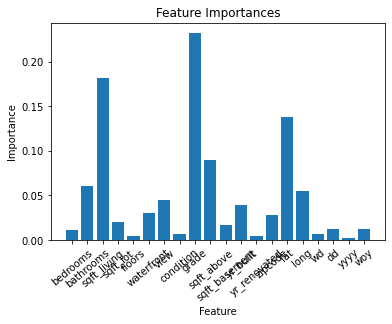

In [14]:
# Feature importance
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [15]:
# Best hyperparameters
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  50
maxDepth -  25
